In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

/tmp/ipykernel_30814/1056814220.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_30814/1056814220.py:25: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana_f", cmap)


## data female

In [5]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_females_raw_usage_df_beh_age.parquet').astype(float)
female_df = female_df[keep_syllables]
f_df= female_df.groupby(['age','uuid']).mean()

## data males

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_males_raw_usage_df_beh_age.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## normalized

In [7]:
# avarage per age or session
f_df= f_df.groupby(['age','uuid']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= m_df.groupby(['age','uuid']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [8]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

# use the same number of mice per age - only age 80

/tmp/ipykernel_30814/4054637843.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_30814/4054637843.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


## pca females

In [9]:
## female
df=f_norm.copy()
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [10]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')
age_pc = pcs.groupby('age').mean()

In [11]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.15986743 0.30280368 0.42426734]


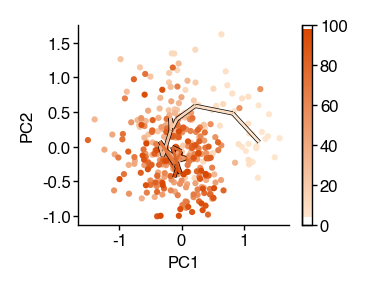

In [12]:
# Create segments for LineCollection
from matplotlib.collections import LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=1.5)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=5,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [0,20,40,60,80,100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])


# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

-0.24881180644095313


/tmp/ipykernel_30814/2159063339.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


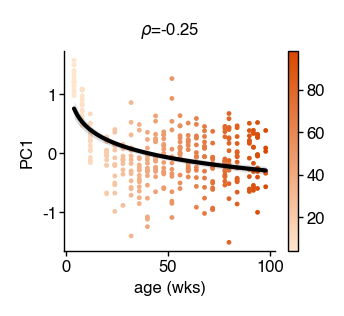

In [13]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)
fig, ax = plt.subplots()
fig.set_size_inches(1.7,1.3) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=3, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmf)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
tick_values = [0,20,40,60,80,100]
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

## pca males

In [14]:
df=m_norm.copy()
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [15]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')
age_pc = pcs.groupby('age').mean()

In [16]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.20714413 0.35734183 0.47016506]


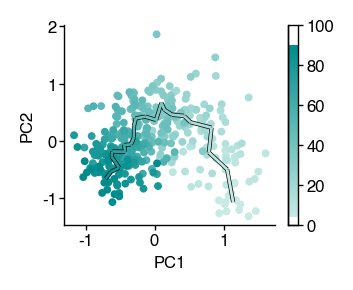

In [17]:
# Create segments for LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=1.5)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmm,
    s=8,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [0,20,40,60,80,100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])
tick_values = [0,20,40,60,80,100]

# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

-0.9036024059273473


/tmp/ipykernel_30814/2921743767.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


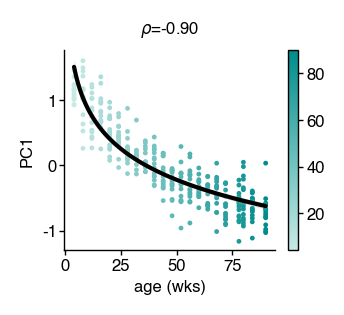

In [18]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)
fig, ax = plt.subplots()
fig.set_size_inches(1.7,1.3) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=3, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
tick_values = [0,20,40,60,80,100]
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

## umaps

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

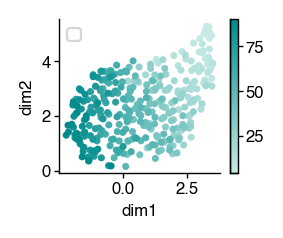

In [19]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df contains your data
# Perform UMAP dimensionality reduction
df = m_norm.copy()
reducer = umap.UMAP(n_components=2, random_state=10, n_neighbors=50)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
age_pc = pcs.groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap=cmm,
    s=3,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]
# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

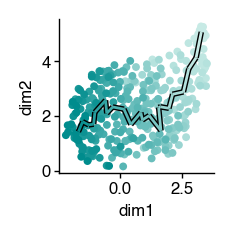

In [20]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='age',palette=cmm, legend=False, s=8, edgecolor='none')

#Create segments for LineCollection
points = np.array([age_pc['dim1'], age_pc['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['dim1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)
# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'UMAP_male_n30.pdf')

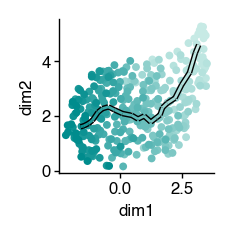

In [22]:
# Create segments for LineCollection
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='age',palette=cmm, legend=False, s=8, edgecolor='none')

# Convert to DataFrame for easier rolling operation
df = pd.DataFrame(age_pc)

# Apply rolling window average
window_size = 3  # Adjust the window size as needed
df_smooth = df.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data
points = np.array([df_smooth['dim1'], df_smooth['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(df_smooth['dim1'])))

# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)

# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [23]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'UMAP_male_n50_smoothen.pdf')

In [24]:
## 3D UMAPS

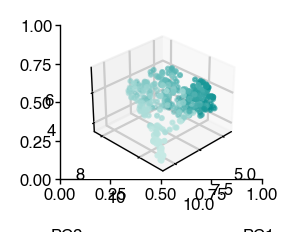

In [25]:
 ## 3D scatter
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module
df = m_norm.copy()
reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, metric='euclidean')
pcs3 = reducer.fit_transform(df)
ages =df.index.get_level_values('age')
pc3_df = pd.DataFrame(pcs3, columns=['UMAP1','UMAP2','UMAP3'])
pc3_df['age'] = df.index.get_level_values('age')
age_pc = pc3_df.groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pc3_df['UMAP1'], pc3_df['UMAP2'], pc3_df['UMAP3'], c=pc3_df['age'], cmap=cmm, s=2)

# Set custom viewing angles (elevation, azimuthal)
ax.view_init( azim=45)
# Set labels for each axis
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
sns.despine()
plt.show()

In [26]:
## for females:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


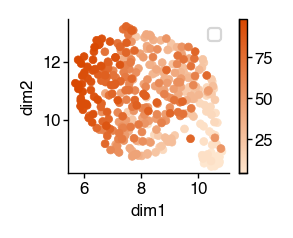

In [27]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df contains your data
# Perform UMAP dimensionality reduction
df=f_norm.copy()
reducer = umap.UMAP(random_state=10,n_neighbors=50, min_dist=0.1)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
age_pc = pcs.groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=8,
    linewidth =0.25,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]

# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data females')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

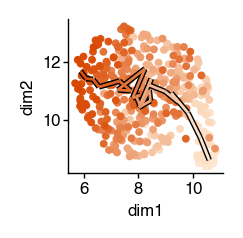

In [28]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='age',palette=cmf, legend=False, s=8, edgecolor='none')
#Create segments for LineCollection
points = np.array([age_pc['dim1'], age_pc['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['dim1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)
# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [29]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'UMAP_female_n30.pdf')

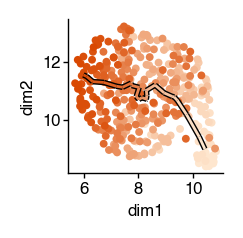

In [30]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='age',palette=cmf, legend=False, s=8, edgecolor='none')


# Convert to DataFrame for easier rolling operation
df = pd.DataFrame(age_pc)

# Apply rolling window average
window_size = 3  # Adjust the window size as needed
df_smooth = df.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data
points = np.array([df_smooth['dim1'], df_smooth['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(df_smooth['dim1'])))

# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)



# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [31]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'UMAP_female_n50_smoothen.pdf')

In [32]:
#joint embeddings

In [33]:
#pca

In [34]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

/tmp/ipykernel_30814/1663783390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_30814/1663783390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [35]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

In [36]:
## joint PCA
data=pd.concat([m_norm,f_norm])
df=data.copy()

In [37]:
pc = PCA(n_components=2)
pcss = pc.fit_transform(df)
pcs = pd.DataFrame(pcss, columns=['PC1','PC2'])
pcs['sex'] = df.index.get_level_values('sex')
pcs['age'] = df.index.get_level_values('age')

spcs = pcs.sample(frac=1).reset_index(drop=True)

In [38]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.1617506  0.29695254]


In [39]:
norm = plt.Normalize(vmin=4, vmax=90)
mask = spcs['sex'] == "m"
c = cmm(norm(spcs.loc[mask, 'age']))
spcs.loc[mask, 'color'] = [str(tuple(x)) for x in c]
mask = spcs['sex'] == "f"
c2 = cmf(norm(spcs.loc[mask, 'age']))
spcs.loc[mask, 'color'] = [str(tuple(x)) for x in c2]

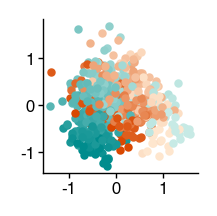

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(1,1) 
for ind, row in spcs.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color=eval(row['color']),s=5, alpha=1)
sns.despine()

In [41]:
## for both sexes:
reducer = umap.UMAP(n_neighbors=30, random_state=0)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
pcs['sex'] = df.index.get_level_values('sex')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


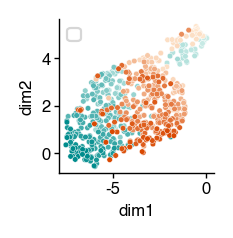

In [42]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)

# Color the points by sex with different palettes
male_df = pcs[pcs['sex'] == 'm']
female_df = pcs[pcs['sex'] == 'f']

sns.scatterplot(data=male_df, x='dim1', y='dim2', hue='age',palette = cmm, ax=ax, legend=False,s=4)
sns.scatterplot(data=female_df, x='dim1', y='dim2',hue='age',palette = cmf, ax=ax, legend=False, s=4)

#plt.title('UMAP Plot both sexes')
plt.xlabel('dim1')
plt.ylabel('dim2')
sns.despine()
plt.legend()
plt.show()

In [43]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'UMAP_fvm_n30.pdf')